In [2]:
import torch
from gpt import *


def text2token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 添加一个维度
    return encoded_tensor


def token_ids2text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


torch.manual_seed(123)
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,  # B
    "qkv_bias": False,
}
model = GPTModel(GPT_CONFIG_124M)
model.eval()


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text2token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids2text(token_ids, tokenizer))



Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [3]:
inputs = torch.tensor(
    [[16833, 3626, 6100], [40, 1107, 588]]  # ["every effort moves",
)  # "I really like"]
targets = torch.tensor(
    [[3626, 6100, 345], [588, 428, 11311]]  # [" effort moves you",
)  # " really like chocolate"]
with torch.no_grad():  # A
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  # 词表中每个 token 的概率
print(probas.shape)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
print(f"Targets batch 1: {token_ids2text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids2text(token_ids[0].flatten(), tokenizer)}")


text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat) # 交叉熵损失
print(loss)
perplexity = torch.exp(loss)
print(perplexity)

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9836e-05, 1.6783e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -10.1307, -10.9951, -12.2561])
tensor(-10.7722)
tensor(10.7722)
Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.7722)
tensor(47678.8633)


In [4]:
## 构造数据集
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)


# 分割一部分作为训练集，一部分作为验证集
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
)

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Characters: 20479
Tokens: 5145
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [5]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            total_loss += loss
        else:
            break
        
    return total_loss / num_batches



device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device) #B
val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(10.9876, grad_fn=<DivBackward0>)
Validation loss: tensor(10.9811, grad_fn=<DivBackward0>)


In [6]:
# 预训练
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
eval_freq, eval_iter, start_context):

    train_losses, val_losses, track_tokens_seen = [], [], [] #A
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs): #B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #D
            optimizer.step() #E
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0: #F
                train_loss, val_loss = evaluate_model(
                model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample( #G
        	model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text2token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids2text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0004, weight_decay=0.1
)  # 使用AdamW优化器
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you"
)


Ep 1 (Step 000000): Train loss 9.148, Val loss 9.932
Ep 1 (Step 000005): Train loss 8.077, Val loss 8.338
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.565, Val loss 7.040
Ep 2 (Step 000015): Train loss 6.024, Val loss 6.591
Every effort moves you, and, and, and, and, and, and, and, and,, and, of the, and, and, and, and, and, and,, and, and, and, and, and, and, of the
Ep 3 (Step 000020): Train loss 15.187, Val loss 15.825
Ep 3 (Step 000025): Train loss 5.171, Val loss 6.374
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss 4.481, Val loss 6.275
Ep 4 (Step 000035): Train loss 4.685, Val loss 6.173
Every effort moves you know the "I the picture.  "I had been. "I was the, and to have to have to have of the, and I was a, and I was, and the, and I was, I was his
Ep 5 (Step 000040): Train loss 3.968, Val loss 6.200
Every effort moves you know it was not to the picture--I was his 

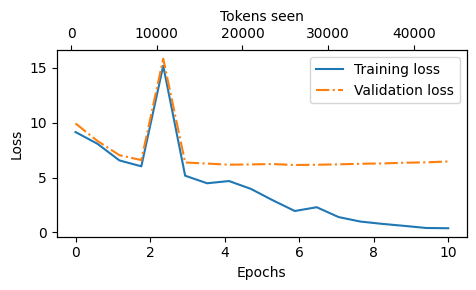

In [7]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [11]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text2token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids2text(token_ids, tokenizer))


Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




forward
toward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


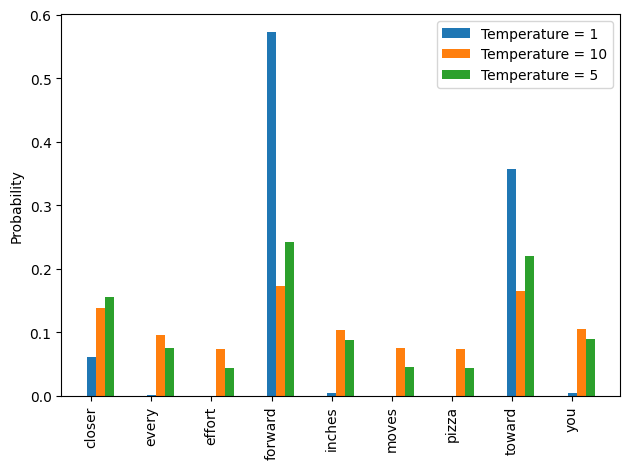

In [ ]:
# 温度缩放
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)] # 使用torch.multinomial函数从probas中进行了1000次采样
    sampled_ids = torch.bincount(torch.tensor(sample)) # 使用torch.bitcount函数统计每个token的采样数量
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    # 条形图的绘制，ax.bar()函数里面的参数分别为条形的x轴位置、高度、宽度、图例标签
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()